In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(tidyr)))
source("../../utils/figure_themes.r")

In [2]:
death_curve_path <- file.path("..","..","..","data","Death_curve_data.csv")
# figure output_path
output_path <- file.path("..","figures")
if (!dir.exists(output_path)){
  dir.create(output_path, recursive = TRUE)
}
oputput_figure_path <- file.path(output_path,"death_curve.png")

death_df <- read.csv(death_curve_path)
head(death_df)

,Photo_num,Live_cells,Dead_cells,Bio_rep,Tech_rep,Compound,Dose,dose_unit,time,time_unit,exp
,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>
1,Photo 1,72,18,1,1,Media,0,,3,Hours,Thapsi_curve
2,Photo 2,87,23,1,2,Media,0,,3,Hours,Thapsi_curve
3,Photo 3,63,15,1,3,Media,0,,3,Hours,Thapsi_curve
4,Photo 4,217,40,1,4,Media,0,,3,Hours,Thapsi_curve
5,Photo 5,137,15,1,5,Media,0,,3,Hours,Thapsi_curve
6,Photo 1,49,16,1,6,Media,0,,3,Hours,Thapsi_curve


In [3]:
# death percentage
# drop the NA values
death_df <- death_df[!is.na(death_df$Dead_cells),]
death_df$percentage_dead_cells <- death_df$Dead_cells/(death_df$Dead_cells + death_df$Live_cells)	*100
death_df$treatment <- paste0(death_df$Compound," ",death_df$Dose," ",death_df$dose_unit, " ",death_df$time, " ", death_df$time_unit)
# aggregate data by treatment
death_df_agg <- death_df %>% group_by(treatment, Compound, dose_unit) %>% summarise(mean_death = mean(percentage_dead_cells), sd_death = sd(percentage_dead_cells), time = mean(time), dose = mean(Dose))
# make dose as factor
death_df_agg$dose <- factor(death_df_agg$dose,levels = c("0","0.1","1","10"))
death_df_agg$treatment <- paste0(death_df_agg$Compound," ",death_df_agg$dose, " ",death_df_agg$dose_unit)
# factorize treatment
unique(death_df_agg$treatment)
death_df_agg$treatment <- factor(death_df_agg$treatment,levels = c(
    'Media 0 ',
    'DMSO 0.1 %',
    'LPS 1 ug/mL',
    'LPS 10 ug/mL',
    'Thapsi 1 uM',
    'Thapsi 10 uM'
))
unique(death_df_agg$treatment)

`summarise()` has grouped output by 'treatment', 'Compound'. You can override
using the `.groups` argument.


[1] "DMSO 0.1 %"   "LPS 1 ug/mL"  "LPS 10 ug/mL" "Media 0 "     "Thapsi 1 uM" 
[6] "Thapsi 10 uM"

[1] DMSO 0.1 %   LPS 1 ug/mL  LPS 10 ug/mL Media 0      Thapsi 1 uM 
[6] Thapsi 10 uM
6 Levels: Media 0  DMSO 0.1 % LPS 1 ug/mL LPS 10 ug/mL ... Thapsi 10 uM

In [4]:
# gsub
death_df_agg$treatment <- gsub("Media 0 ","Media",death_df_agg$treatment)
death_df_agg$treatment <- gsub("DMSO 0.1 %","DMSO 0.1%",death_df_agg$treatment)
death_df_agg$treatment <- gsub("LPS 1 ug/mL","LPS 1.0 ug/mL",death_df_agg$treatment)
death_df_agg$treatment <- gsub("LPS 10 ug/mL","LPS 10.0 ug/mL",death_df_agg$treatment)
death_df_agg$treatment <- gsub("Thapsi 1 uM","Thapsigargin 1.0 uM",death_df_agg$treatment)
death_df_agg$treatment <- gsub("Thapsi 10 uM","Thapsigargin 10.0 uM",death_df_agg$treatment)
# factorize treatment
death_df_agg$time <- paste0(death_df_agg$time," Hours")
death_df_agg$treatment <- factor(death_df_agg$treatment,levels = c(
    'Media',
    'DMSO 0.1%',
    'LPS 1.0 ug/mL',
    'LPS 10.0 ug/mL',
    'Thapsigargin 1.0 uM',
    'Thapsigargin 10.0 uM'
))
head(death_df_agg)


treatment,Compound,dose_unit,mean_death,sd_death,time,dose
<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
DMSO 0.1%,DMSO,%,19.34768,5.872366,3 Hours,0.1
DMSO 0.1%,DMSO,%,21.30483,4.233420,6 Hours,0.1
DMSO 0.1%,DMSO,%,23.49166,5.359381,9 Hours,0.1
LPS 1.0 ug/mL,LPS,ug/mL,21.48716,4.833199,3 Hours,1
LPS 1.0 ug/mL,LPS,ug/mL,27.41013,6.957607,6 Hours,1
LPS 1.0 ug/mL,LPS,ug/mL,23.31267,5.202596,9 Hours,1


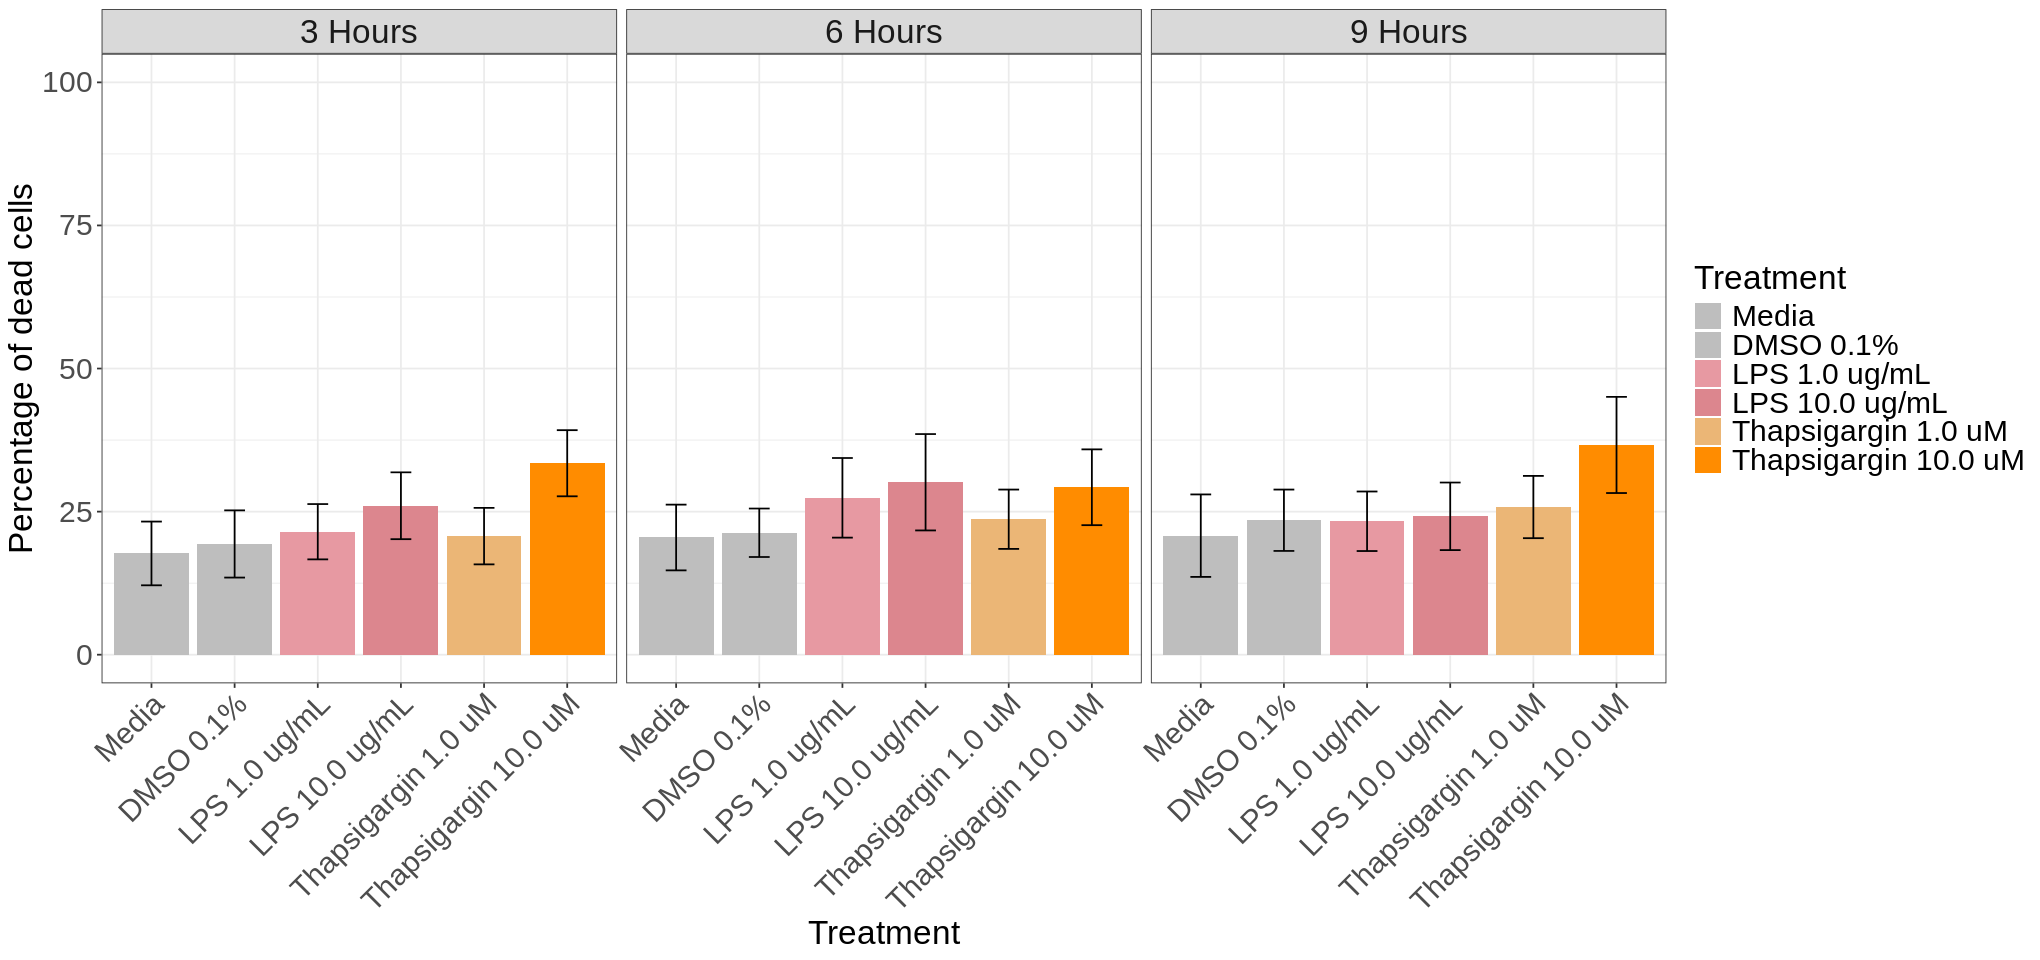

In [5]:
# plot the death curve data 
width <- 17
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
death_curve_plot <- (
    ggplot(death_df_agg, aes(x = treatment, y = mean_death, fill = treatment))
    + geom_bar(stat = "identity", position = "dodge")
    + geom_errorbar(aes(ymin = mean_death - sd_death, ymax = mean_death + sd_death), width = 0.25, position = position_dodge(0.9))
    + theme_bw()
    + figure_theme
    + ylim(0, 100)
    + labs(
           x = "Treatment",
           y = "Percentage of dead cells")
    + facet_grid(~time)
    + theme(
        axis.text.x = element_text(size = 18, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 18),
        axis.title = element_text(size = 20),
        strip.text = element_text(size = 20),
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 20),
    )
    + scale_fill_manual(
        name = "Treatment",
        labels = c(
            'Media',
            'DMSO 0.1%',
            'LPS 1.0 ug/mL',
            'LPS 10.0 ug/mL',
            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM'
        ),
        values = death_curve_colors)
)
# save the plot
ggsave(oputput_figure_path, plot = death_curve_plot, width = width, height = height, units = "in")
death_curve_plot

In [6]:
# zoom in the plot
death_curve_plot <- (
    death_curve_plot
    + ylim(0, 50)
) 
death_curve_plot
oputput_figure_zoomed_path <- file.path(output_path,"death_curve_zoomed.png")
ggsave(oputput_figure_zoomed_path, plot = death_curve_plot, width = width, height = height, units = "in")

ERROR: Error in parse(text = x, srcfile = src): <text>:5:2: unexpected input
4:     + ylim(0, 50)
5: ) 
    ^
